## Decision Tree Regression

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

## Reading the dataset

In [2]:
import pandas as pd
df = pd.read_csv('50_Startups.csv')
df.head()

,RND,ADMIN,MKT,STATE,PROFIT
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RND     50 non-null     float64
 1   ADMIN   50 non-null     float64
 2   MKT     50 non-null     float64
 3   STATE   50 non-null     object 
 4   PROFIT  50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [7]:
df.isna().sum()

RND       0
ADMIN     0
MKT       0
STATE     0
PROFIT    0
dtype: int64

## Preprocessing

In [8]:
# Seperate X and Y
X = df.drop(labels=['PROFIT'],axis=1)
Y = df[['PROFIT']]

In [9]:
X.head()

,RND,ADMIN,MKT,STATE
0,165349.20,136897.80,471784.10,New York
1,162597.70,151377.59,443898.53,California
2,153441.51,101145.55,407934.54,Florida
3,144372.41,118671.85,383199.62,New York
4,142107.34,91391.77,366168.42,Florida


In [10]:
Y.head()

,PROFIT
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


## Pipeline

1.Con : Simple Imputer Mean, median ; Standardscaler

2.Cat : Simple Imputer Most Frequent ; OneHotEncode

In [11]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [12]:
cat

['STATE']

In [13]:
con

['RND', 'ADMIN', 'MKT']

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [15]:
num_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='mean')),
                           ('scaler',StandardScaler())])

cat_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                           ('ohe',OneHotEncoder(handle_unknown='ignore'))])

pre = ColumnTransformer([('con',num_pipe,con),
                         ('cat',cat_pipe,cat)])

In [16]:
X_pre = pre.fit_transform(X)
X_pre[0:5]

array([[ 2.01641149,  0.56075291,  2.15394309,  0.        ,  0.        ,
         1.        ],
       [ 1.95586034,  1.08280658,  1.9236004 ,  1.        ,  0.        ,
         0.        ],
       [ 1.75436374, -0.72825703,  1.62652767,  0.        ,  1.        ,
         0.        ],
       [ 1.55478369, -0.09636463,  1.42221024,  0.        ,  0.        ,
         1.        ],
       [ 1.5049372 , -1.07991935,  1.28152771,  0.        ,  1.        ,
         0.        ]])

In [17]:
cols = pre.get_feature_names_out()
cols

array(['con__RND', 'con__ADMIN', 'con__MKT', 'cat__STATE_California',
       'cat__STATE_Florida', 'cat__STATE_New York'], dtype=object)

In [18]:
X_pre = pd.DataFrame(X_pre,columns=cols)
X_pre.head()

,con__RND,con__ADMIN,con__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
0,2.016411,0.560753,2.153943,0.0,0.0,1.0
1,1.955860,1.082807,1.923600,1.0,0.0,0.0
2,1.754364,-0.728257,1.626528,0.0,1.0,0.0
3,1.554784,-0.096365,1.422210,0.0,0.0,1.0
4,1.504937,-1.079919,1.281528,0.0,1.0,0.0


## Train Test Split

In [19]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2,random_state=21)

In [20]:
xtrain.shape

(40, 6)

In [21]:
xtest.shape

(10, 6)

## Create the model

In [22]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(xtrain,ytrain)

DecisionTreeRegressor()

In [23]:
# Training r2
dtr.score(xtrain,ytrain)

1.0

In [24]:
# Testing r2
dtr.score(xtest,ytest)

0.8901204811061317

## Tuning the model

In [25]:
params = {'max_depth':[2,3,4,5,6,7,8,9,10],          
          'criterion':['squared_error','absolute_error']}

In [26]:
from sklearn.model_selection import GridSearchCV
model = DecisionTreeRegressor(random_state=42)
gscv = GridSearchCV(model,param_grid=params,cv=5,scoring='neg_mean_squared_error')
gscv.fit(xtrain,ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_mean_squared_error')

In [27]:
gscv.best_params_

{'criterion': 'absolute_error', 'max_depth': 5}

In [28]:
gscv.best_score_

-252871442.10242313

In [29]:
best_dtr = gscv.best_estimator_
best_dtr

DecisionTreeRegressor(criterion='absolute_error', max_depth=5, random_state=42)

## Evaluate R2 in Training and Testing

In [30]:
best_dtr.score(xtrain,ytrain)

0.9973127070752787

In [31]:
best_dtr.score(xtest,ytest)

0.8783765460868838

## Plotting the base model decision tree

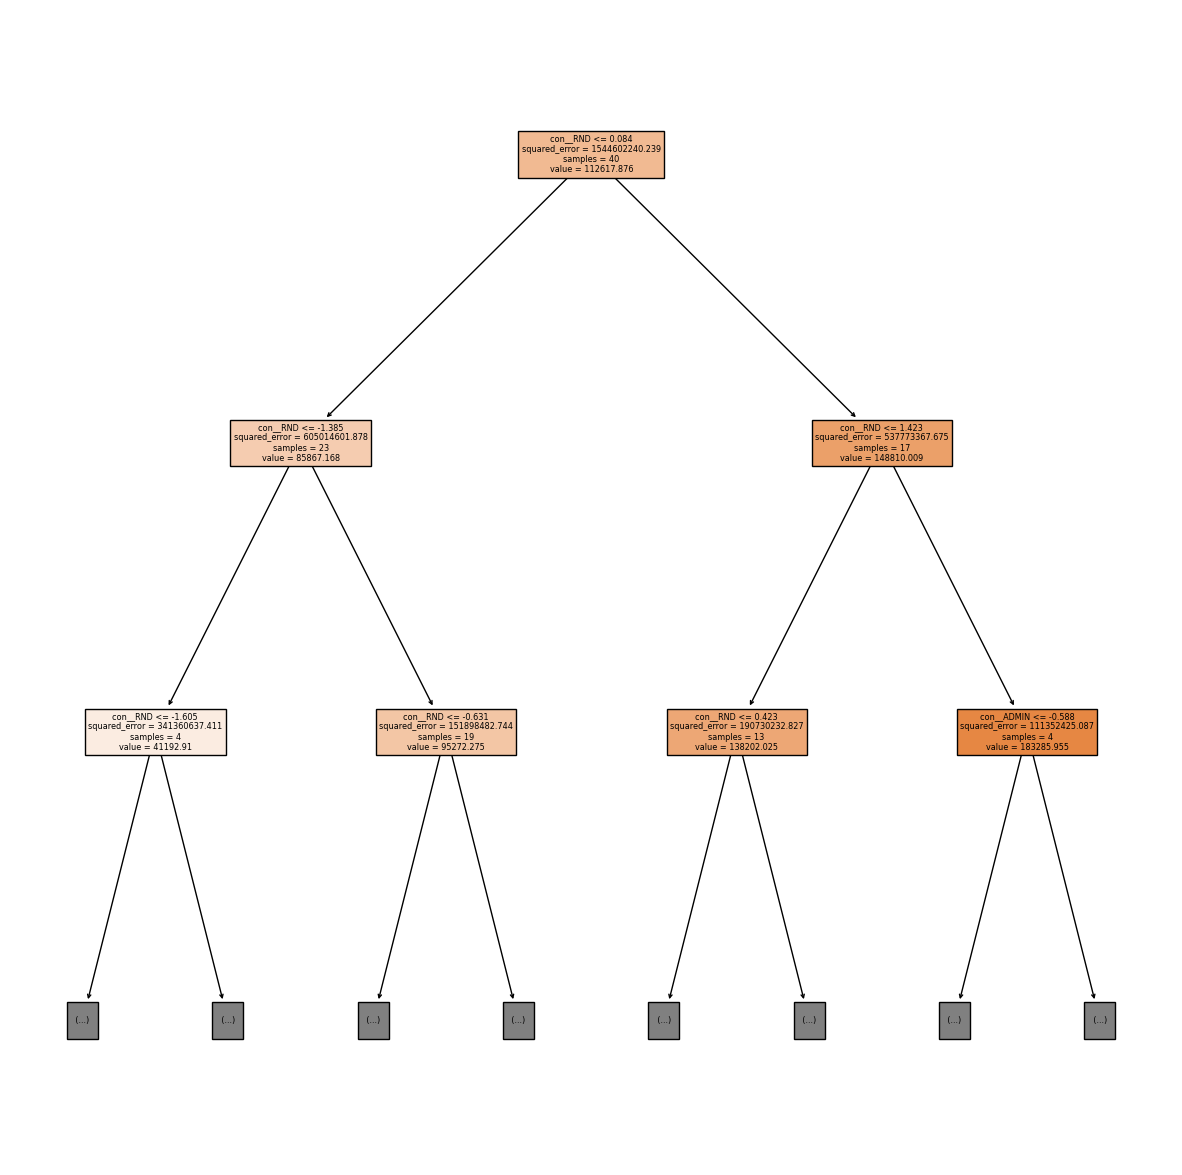

In [32]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plot_tree(dtr,filled=True,feature_names=list(xtrain.columns),max_depth=2)
plt.show()

## Feature Importances

In [33]:
imp = dtr.feature_importances_
imp

array([9.75804750e-01, 6.64971631e-03, 9.88156748e-03, 1.63324771e-03,
       1.04935351e-05, 6.02022467e-03])

In [34]:
imp = pd.Series(imp)
imp.index = xtrain.columns
imp

con__RND                 0.975805
con__ADMIN               0.006650
con__MKT                 0.009882
cat__STATE_California    0.001633
cat__STATE_Florida       0.000010
cat__STATE_New York      0.006020
dtype: float64

In [35]:
imp = imp.sort_values(ascending=False)
imp

con__RND                 0.975805
con__MKT                 0.009882
con__ADMIN               0.006650
cat__STATE_New York      0.006020
cat__STATE_California    0.001633
cat__STATE_Florida       0.000010
dtype: float64

<Axes: title={'center': 'Feature Importances'}>

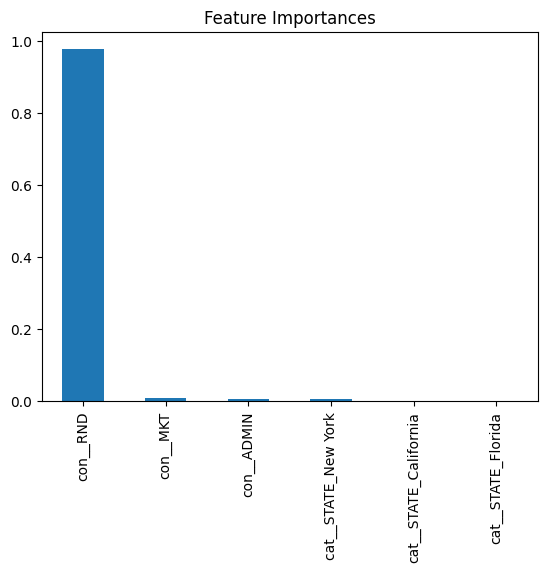

In [36]:
imp.plot(kind='bar',title='Feature Importances')

In [37]:
df_pre = X_pre.join(Y)

In [38]:
df_pre[df_pre['con__RND']<=0.084].mean()

con__RND                    -0.692463
con__ADMIN                  -0.166211
con__MKT                    -0.488150
cat__STATE_California        0.379310
cat__STATE_Florida           0.310345
cat__STATE_New York          0.310345
PROFIT                   85037.441379
dtype: float64

1. Feature Selection - Ordinal Encoder

2. Final Model - Onehotencoder

## MSE, MAE , RMSE

In [39]:
ypred_tr = dtr.predict(xtrain)
ypred_ts = dtr.predict(xtest)

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(ytest,ypred_ts)
mse 

195008332.14419007

In [41]:
rmse = mse**(1/2)
rmse

13964.538379201444

In [42]:
mae = mean_absolute_error(ytest,ypred_ts)
mae

10188.723000000002

In [43]:
r2 = r2_score(ytest,ypred_ts)
r2

0.8901204811061317

In [44]:
dtr.score(xtest,ytest)

0.8901204811061317

In [45]:
df_pre.to_csv('pre.csv')